In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression # Import the Logistic Regression class
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score,roc_curve, balanced_accuracy_score, recall_score
from sklearn.impute import KNNImputer   
import pickle

import missingno as msno
sns.set()
print('Done importing the libraries.')

Done importing the libraries.


In [2]:
# Loading the dataset into variable 'data'
raw_data = pd.read_csv("diabetes.csv")
print('Dataset loaded successfully.')

Dataset loaded successfully.


In [3]:
# Display the first few rows to understand the structure of the dataset
raw_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols, int or float ones will come
    # numeric but will be removed from the list of categorical ones
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')  # this list was created for reporting purposes only, normally this list is contained in cat_cols
    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(raw_data)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


Perform target variable analysis (average of target variable according to categorical variables, average of numeric variables according to target variable)

In [5]:
raw_data.groupby(cat_cols)["Outcome"].mean()
raw_data.groupby("Outcome")[num_cols].mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [6]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(raw_data, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


Analyze missing observations.¶

In [7]:
raw_data.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [8]:
raw_data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

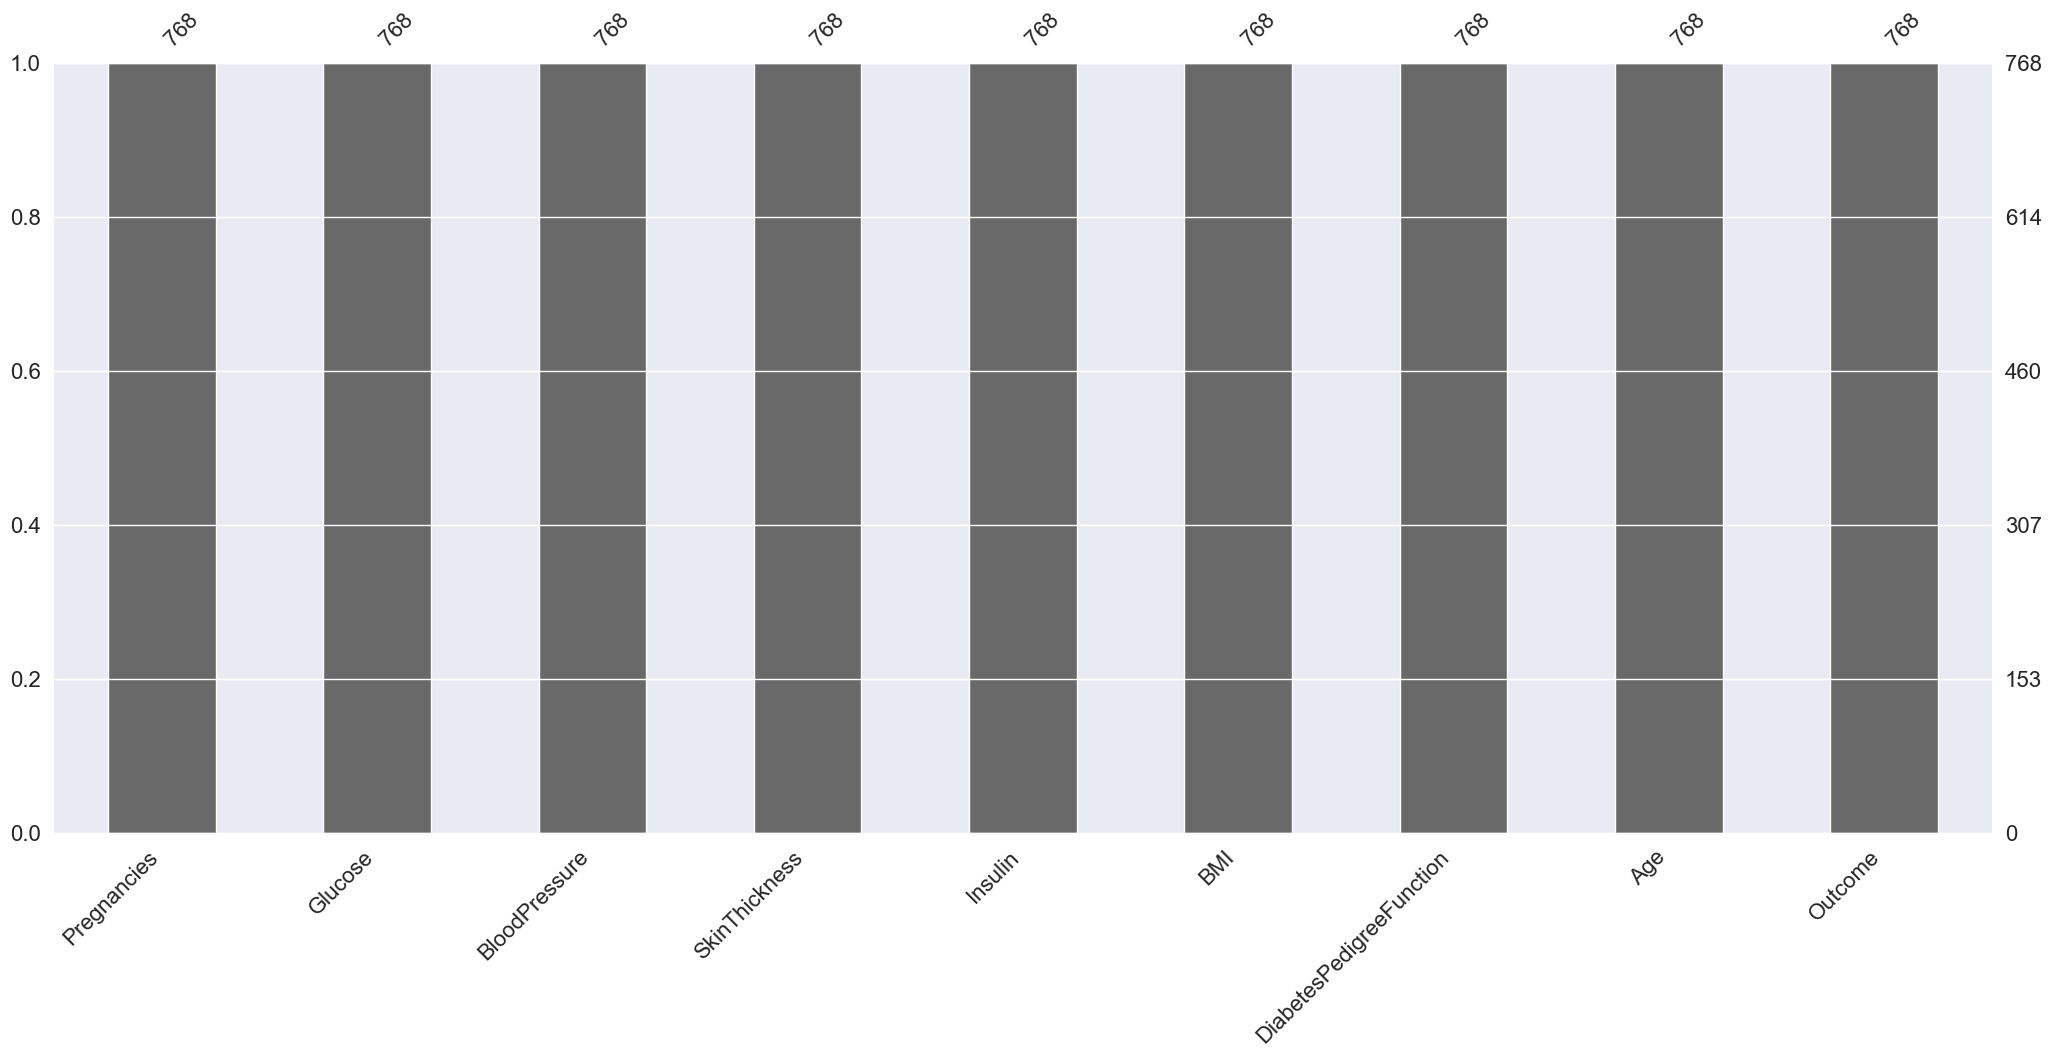

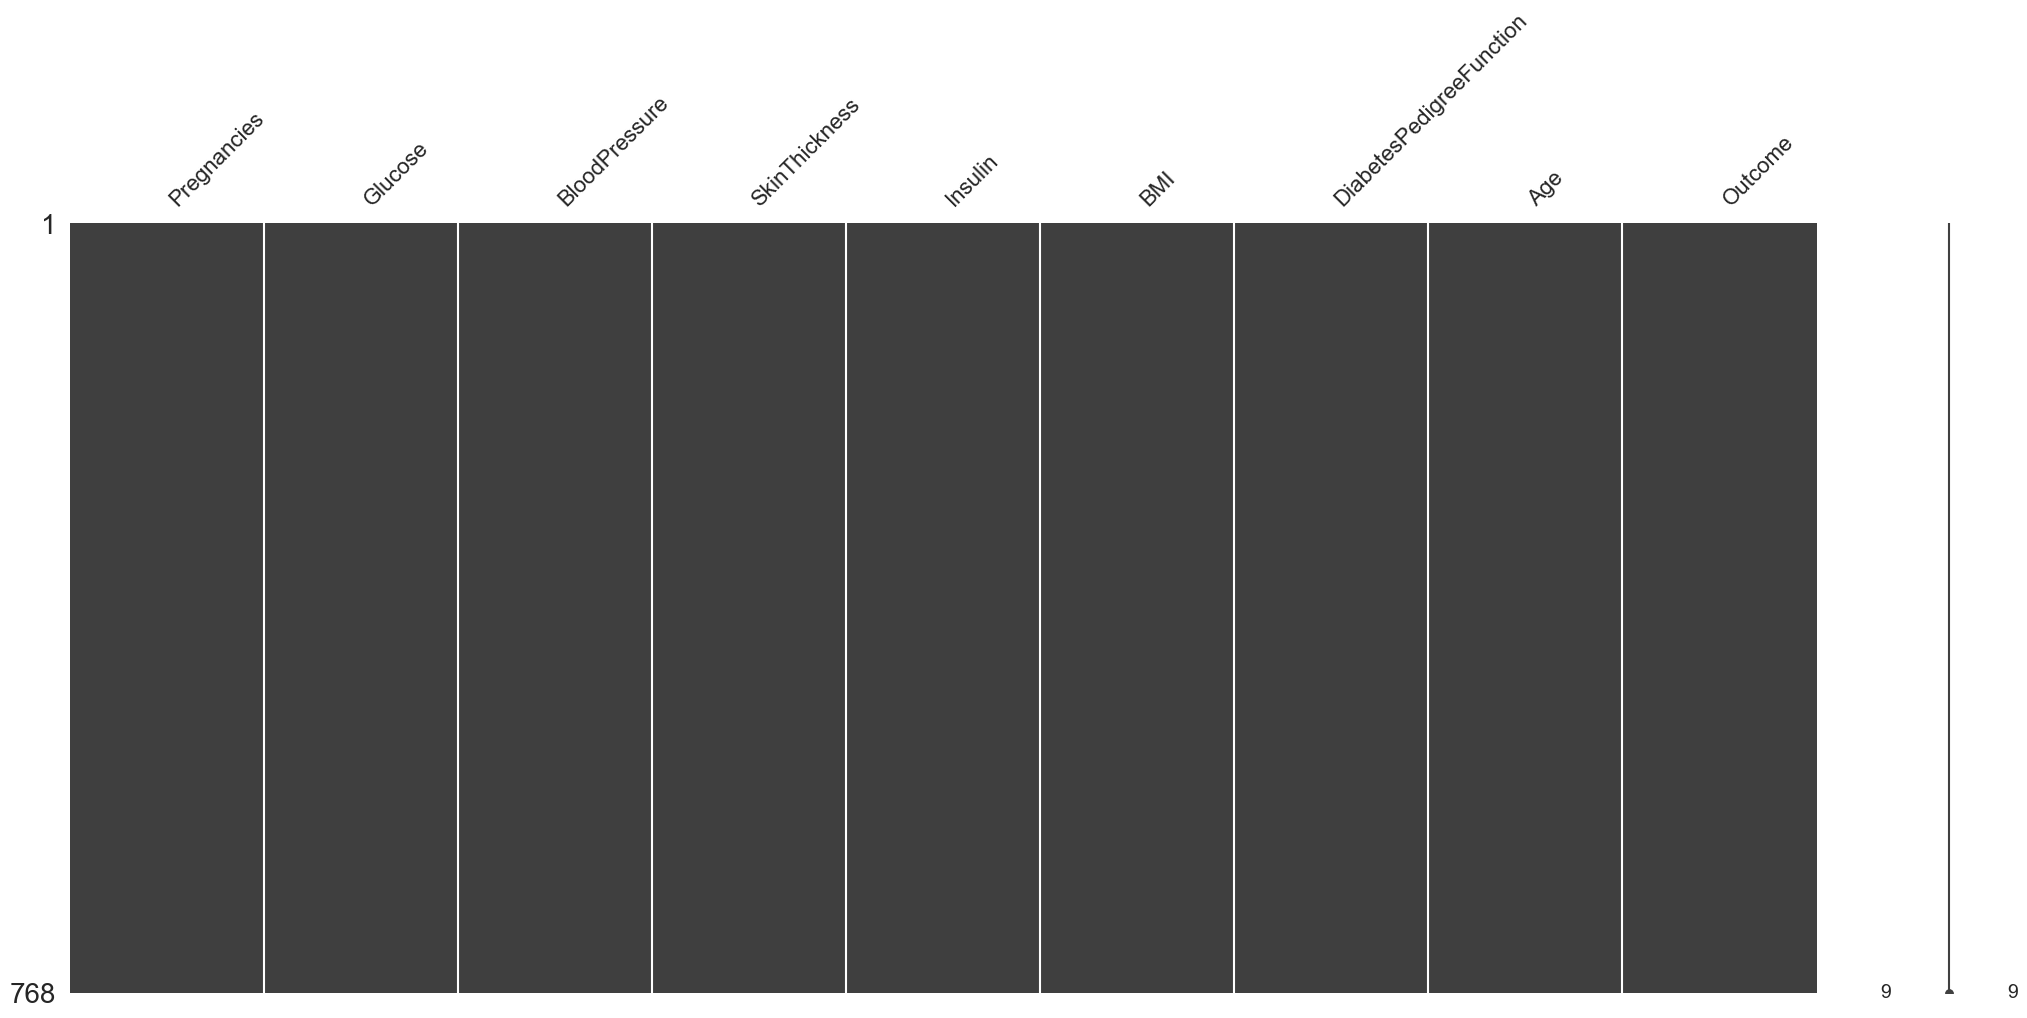

/Users/Oreoluwa/Documents/Final Year Project/Project code/myenv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/Users/Oreoluwa/Documents/Final Year Project/Project code/myenv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


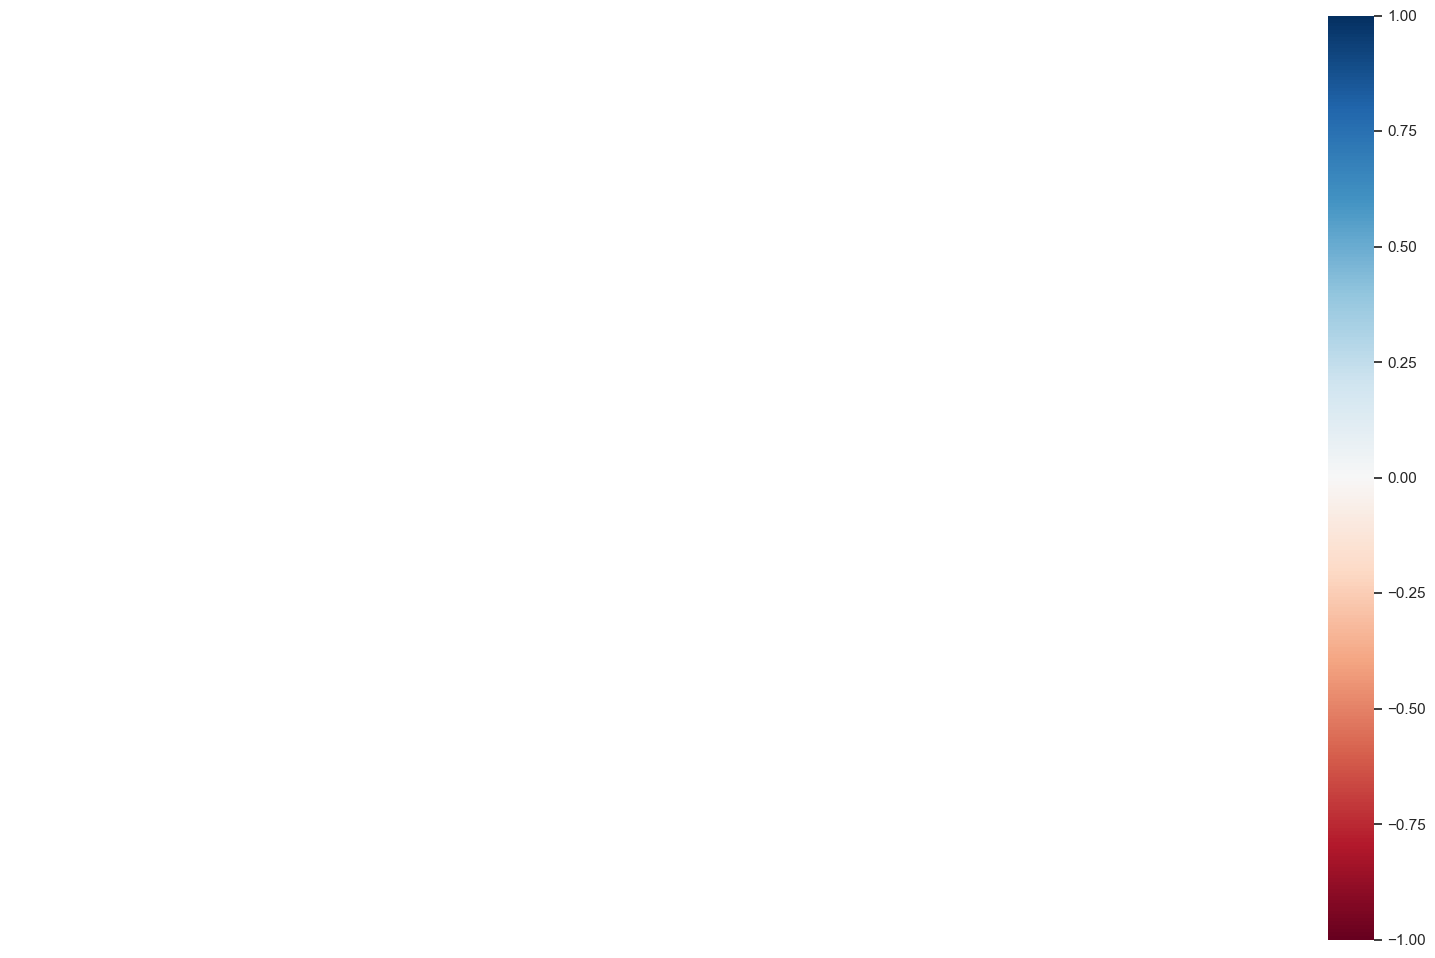

In [9]:
msno.bar(raw_data)
plt.show(block=True)

msno.matrix(raw_data)
plt.show(block=True)

msno.heatmap(raw_data)     
plt.show(block=True)

#msno shows observations between missing values, seaborn shows correlation in the data
#graphing reveals that insulin and skinthickness loss values appear together in 70% of cases



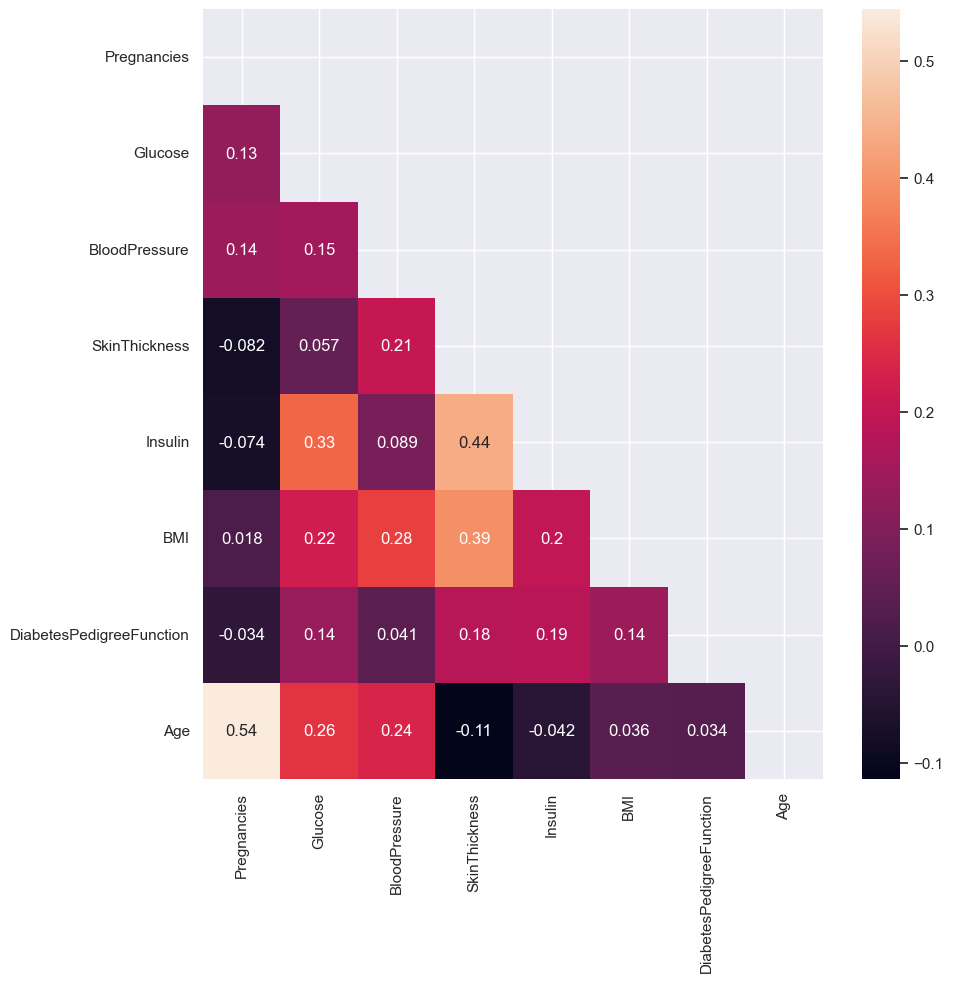

In [10]:
corr=raw_data[num_cols].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr))   #Mask added so that the top of the correlation matrix is not shown
corr = raw_data[num_cols].corr(numeric_only=True)
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True, mask=mask)
plt.show()

Feature Engineering

Take necessary actions for missing and outliers. There are no missing observations in the dataset, but observation units containing 0 values in variables such as Glucose, Insulin, etc. may represent missing values. For example, a person will not have a glucose or insulin value. Considering this situation, assign the zero values as NaN in the relevant values and then You can apply the operations to the missing values.

In [11]:
#numeric columns were assigned Nan
def find_zero_value(raw_data, col, bool_value=False):
    count = raw_data[raw_data[col] == 0][col].count()
    print(" variable : " + str(col) + " --> count of zero's : " + str(count) )
    #if True is set, the next function will replace zero with NaN
    if bool_value:
        if count >0:    #will do this if the number 0 in the variable is greater than 0
            return True
        else :
            return False

for col in raw_data.columns:
    find_zero_value(raw_data, col)

def assing_nan(raw_data, col):
    returning_value = find_zero_value(raw_data, col, True)
    if returning_value :
        raw_data[col] = raw_data[col].replace(0, np.NaN)
        print("------------------------------------")
        print("Varible assigned NaN : " + str(col))
        print("#####################################")

num_cols_not_in_pregnancies = [col for col in num_cols if col not in "Pregnancies"]   #pregnancies must be zero

for col in num_cols_not_in_pregnancies:
    assing_nan(raw_data, col)

 variable : Pregnancies --> count of zero's : 111
 variable : Glucose --> count of zero's : 5
 variable : BloodPressure --> count of zero's : 35
 variable : SkinThickness --> count of zero's : 227
 variable : Insulin --> count of zero's : 374
 variable : BMI --> count of zero's : 11
 variable : DiabetesPedigreeFunction --> count of zero's : 0
 variable : Age --> count of zero's : 0
 variable : Outcome --> count of zero's : 500
 variable : Glucose --> count of zero's : 5
------------------------------------
Varible assigned NaN : Glucose
#####################################
 variable : BloodPressure --> count of zero's : 35
------------------------------------
Varible assigned NaN : BloodPressure
#####################################
 variable : SkinThickness --> count of zero's : 227
------------------------------------
Varible assigned NaN : SkinThickness
#####################################
 variable : Insulin --> count of zero's : 374
------------------------------------
Varible a

--> Missing values to be filled, we can choose to fill this by fitting the model

--> We will use a modeling technique, we need to return the variables to the standard that the model accepts 
--> KNN is a distance-based algorithm, so variables need to be standardized 
--> Standardization of variables, roboust scaler is more appropriate because it allows me to take outliers into account

In [12]:
scaler = MinMaxScaler()
raw_dataf = pd.DataFrame(scaler.fit_transform(raw_data), columns=raw_data.columns)
raw_dataf.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,NaN,0.314928,0.234415,0.483333,1.0
1,0.058824,0.264516,0.428571,0.239130,NaN,0.171779,0.116567,0.166667,0.0
2,0.470588,0.896774,0.408163,NaN,NaN,0.104294,0.253629,0.183333,1.0
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0.0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1.0


For KNN

In [13]:
imputer = KNNImputer(n_neighbors=5)     
raw_dataf = pd.DataFrame(imputer.fit_transform(raw_dataf), columns=raw_dataf.columns)
raw_dataf.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.384856,0.314928,0.234415,0.483333,1.0
1,0.058824,0.264516,0.428571,0.239130,0.050721,0.171779,0.116567,0.166667,0.0
2,0.470588,0.896774,0.408163,0.273913,0.269231,0.104294,0.253629,0.183333,1.0
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0.0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1.0


In [14]:
raw_data["Glucose_assigned_by_knn"] = raw_dataf[["Glucose"]]
raw_data.loc[raw_data["Glucose"].isnull(), :]

raw_data["BloodPressure_assigned_by_knn"] = raw_dataf[["BloodPressure"]]
raw_data.loc[raw_data["BloodPressure"].isnull(), :]

raw_data["SkinThickness_assigned_by_knn"] = raw_dataf[["SkinThickness"]]
raw_data.loc[raw_data["SkinThickness"].isnull(), :]

raw_data["Insulin_assigned_by_knn"] = raw_dataf[["Insulin"]]
raw_data.loc[raw_data["Insulin"].isnull(), :]

raw_data["BMI_assigned_by_knn"] = raw_dataf[["BMI"]]
raw_data.loc[raw_data["BMI"].isnull(), :]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_assigned_by_knn,BloodPressure_assigned_by_knn,SkinThickness_assigned_by_knn,Insulin_assigned_by_knn,BMI_assigned_by_knn
9,8,125.0,96.0,NaN,NaN,NaN,0.232,54,1,0.522581,0.734694,0.273913,0.330769,0.318609
49,7,105.0,NaN,NaN,NaN,NaN,0.305,24,0,0.393548,0.432653,0.265217,0.133173,0.183640
60,2,84.0,NaN,NaN,NaN,NaN,0.304,21,0,0.258065,0.508163,0.097826,0.043510,0.150102
81,2,74.0,NaN,NaN,NaN,NaN,0.102,22,0,0.193548,0.336735,0.121739,0.033654,0.085481
145,0,102.0,75.0,23.0,NaN,NaN,0.572,21,0,0.374194,0.520408,0.173913,0.097356,0.350102
371,0,118.0,64.0,23.0,89.0,NaN,1.731,21,0,0.477419,0.408163,0.173913,0.090144,0.184049
426,0,94.0,NaN,NaN,NaN,NaN,0.256,25,0,0.322581,0.493878,0.280435,0.106731,0.355010
494,3,80.0,NaN,NaN,NaN,NaN,0.174,22,0,0.232258,0.522449,0.134783,0.049038,0.243354
522,6,114.0,NaN,NaN,NaN,NaN,0.189,26,0,0.451613,0.502041,0.267391,0.159615,0.242945
684,5,136.0,82.0,NaN,NaN,NaN,0.640,69,0,0.593548,0.591837,0.167391,0.199760,0.183640


In [15]:
#NA values have been assigned but there are still values that are 0. Let's use the median for this

data = pd.DataFrame(["Pregnancies", "Glucose","BloodPressure","SkinThickness","Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"  ])
data = raw_data.loc[ : ,["Pregnancies", "Glucose_assigned_by_knn", "BloodPressure_assigned_by_knn","SkinThickness_assigned_by_knn", "Insulin_assigned_by_knn","BMI_assigned_by_knn","DiabetesPedigreeFunction", "Age", "Outcome" ] ]

data.rename(columns = {'Glucose_assigned_by_knn':'Glucose', 'BloodPressure_assigned_by_knn':'BloodPressure',
                         'SkinThickness_assigned_by_knn': 'SkinThickness', 'Insulin_assigned_by_knn': 'Insulin',
                         'BMI_assigned_by_knn': 'BMI'}, inplace = True)

data.isnull().sum().sum()  
data[data["Glucose"] == 0]        # 1 value 0
data[data["BloodPressure"] == 0]  # 1 value 0
data[data["SkinThickness"] == 0]  # 2 value 0
data[data["Insulin"] == 0]        # 1 value 0
data[data["BMI"] == 0]            # 3 value 0

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
418,1,0.251613,0.448980,0.095652,0.050240,0.0,0.624,27,0
438,1,0.341935,0.469388,0.086957,0.047596,0.0,0.147,21,0
526,1,0.341935,0.408163,0.130435,0.081731,0.0,0.299,21,0


In [16]:
#It makes sense to take the median of the disease breakdown and fill it in because the number of values with 0 is small
glucose_outcome_median = data.groupby("Outcome").agg({"Glucose":"median"}).reset_index()["Glucose"][0]    #median value of outcome 0
data["Glucose"]  = data["Glucose"] .replace(0, glucose_outcome_median)
data[data["Glucose"] == 0]
########################################## for BloodPressure 
BloodPressure_outcome_median = data.groupby("Outcome").agg({"BloodPressure":"median"}).reset_index()["BloodPressure"][0]    #median value of outcome 0
data["BloodPressure"]  = data["BloodPressure"] .replace(0, BloodPressure_outcome_median)
data[data["BloodPressure"] == 0]
########################################## for SkinThickness 
SkinThickness_outcome_median = data.groupby("Outcome").agg({"SkinThickness":"median"}).reset_index()["SkinThickness"][0]    # here comes 0 and 1 I took 0, the median value of outcome 0
data["SkinThickness"]  = data["SkinThickness"] .replace(0, SkinThickness_outcome_median)
data[data["SkinThickness"] == 0]
########################################## for Insulin 
Insulin_outcome_median = data.groupby("Outcome").agg({"Insulin":"median"}).reset_index()["Insulin"][1]    #here the row with outcome 1 is empty, the median value of outcome 1
data["Insulin"]  = data["Insulin"] .replace(0, Insulin_outcome_median)
data[data["Insulin"] == 0]
########################################## for BMI 
BMI_outcome_median = data.groupby("Outcome").agg({"BMI":"median"}).reset_index()["BMI"][1]    #here the row with outcome 0 is empty, the median value of outcome 1
data["BMI"]  = data["BMI"] .replace(0, BMI_outcome_median)
data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.00
Glucose,768.0,0.501647,0.196146,0.077419,0.354839,0.470968,0.625806,1.00
BloodPressure,768.0,0.493537,0.123051,0.061224,0.408163,0.489796,0.571429,1.00
SkinThickness,768.0,0.240823,0.101823,0.010870,0.173913,0.239130,0.304348,1.00
Insulin,768.0,0.167743,0.117993,0.001202,0.091106,0.139423,0.210096,1.00
BMI,768.0,0.292030,0.139941,0.004090,0.190184,0.288344,0.376278,1.00
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.42
Age,768.0,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.00
Outcome,768.0,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.00


Create new variables.

In [18]:
data["Glucose_Insulin_Ratio"] = data["Glucose"] / data["Insulin"]
data["Skin_BMI_Ratio"] = data["SkinThickness"] / data["BMI"]
data["General_Glucose"] = data["DiabetesPedigreeFunction"] * data["Glucose"]

In [19]:
data.isnull().sum().sum()
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.0,0.501647,0.196146,0.077419,0.354839,0.470968,0.625806,1.000000
BloodPressure,768.0,0.493537,0.123051,0.061224,0.408163,0.489796,0.571429,1.000000
SkinThickness,768.0,0.240823,0.101823,0.010870,0.173913,0.239130,0.304348,1.000000
Insulin,768.0,0.167743,0.117993,0.001202,0.091106,0.139423,0.210096,1.000000
BMI,768.0,0.292030,0.139941,0.004090,0.190184,0.288344,0.376278,1.000000
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.0,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.0,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000
Glucose_Insulin_Ratio,768.0,4.427042,7.572801,0.732798,2.501174,3.393175,4.496494,128.825806


Perform encoding operations.

In [20]:
scalar_fitting = StandardScaler()
data[["Pregnancies", "Glucose","BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age","Glucose_Insulin_Ratio","Skin_BMI_Ratio", "General_Glucose" ]] = scalar_fitting.fit_transform(data[["Pregnancies","Glucose","BloodPressure", "SkinThickness", "Insulin", "BMI","DiabetesPedigreeFunction", "Age","Glucose_Insulin_Ratio","Skin_BMI_Ratio", "General_Glucose"]])
print("Fitting Completed")

Fitting Completed


Modelling

In [21]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_Insulin_Ratio,Skin_BMI_Ratio,General_Glucose
0,0.639947,0.863804,-0.030426,0.624280,1.841240,0.163738,0.468492,1.425995,1,-0.354606,-0.024183,0.737727
1,-0.844885,-1.209737,-0.528305,-0.016635,-0.992415,-0.859852,-0.365061,-0.190672,0,0.104133,0.426734,-0.645431
2,1.233880,2.015772,-0.694265,0.325186,0.860673,-1.342401,0.604397,-0.105584,1,-0.144845,1.734179,1.505286
3,-0.844885,-1.078084,-0.528305,-0.657549,-0.607119,-0.640511,-0.920763,-1.041549,0,-0.186008,-0.137927,-0.832585
4,-1.141852,0.501757,-2.685783,0.624280,0.147163,1.552896,5.484909,-0.020496,1,-0.156647,-0.414752,4.754512


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
training_set_row = X_train.shape[0]
test_set_row = X_test.shape[0]
training_set_col = X_train.shape[1]
test_set_col = X_train.shape[1]
raw_data.shape
raw_data_row = raw_data.shape[0]
raw_data_col = raw_data.shape[1]

training_set = (training_set_row/raw_data_row)
test_set = (test_set_row/raw_data_row)

print("The training data has",training_set_row,"rows and",training_set_col,"columns.")
print("The testing data has",test_set_row,"rows and",test_set_col,"columns.")
print()
print("The model is being trained using " , training_set *100,"%"," of the dataset.")
print("The model is being tested using " , test_set *100,"%"," of the dataset.")

The training data has 614 rows and 11 columns.
The testing data has 154 rows and 11 columns.

The model is being trained using  79.94791666666666 %  of the dataset.
The model is being tested using  20.052083333333336 %  of the dataset.


Logistic Regression

In [24]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)


# log_model = LogisticRegression()
# log_model.fit(X_train, Y_train)
# y_pred_log_reg = log_model.predict(X_test)
# log_reg_accuracy = accuracy_score(y_pred_log_reg, Y_test)
# log_reg_accuracy 

# Make predictions
y_pred = model.predict(X_test)

In [25]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

print(accuracy)

0.7467532467532467
